# q3dfit notebook: rest-frame optical, JWST/NIRSpec data of J1652 (SDSSJ165202.64+172852.3) from [Wylezalek et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221010074W/abstract)

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://q3d.github.io/) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Initializing the fit](#chapter1_1)
    * [1.2. Setting up the data and models](#chapter1_2)
    * [1.3. Setting up the fitting parameters](#chapter1_3)
        * [1.3.1. Emission line parameters](#chapter1_3_1)
        * [1.3.2. Continuum parameters](#chapter1_3_2)
* [2. Run fitting](#chapter2)
* [3. Plot fit](#chapter3)
* [4. Combine fit results for entire cube](#chapter4)
* [5. Map fit results](#chapter5)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [2]:
import os.path
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
#import sys
#sys.path.append("../")

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [4]:
# Base directory (book-keeping)
volume = 'nirspec-j1652/'
# prefix label for output files
label = 'j1652'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = outdir+label+'-fitlog.txt'

Download data from public Box folder:

In [5]:
# make tuples of urls and download filenames
# infile = data cube
infile_tup=('https://rhodes.box.com/shared/static/scu2ydokah2wcqtfsh1tg2y76m75b91q.fits','nirspec-j1652.fits')
# download files; by default don't force overwrite and take first element of output
from q3dfit.jnb import download_files
infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
infile = initdir+infile

nirspec-j1652.fits already exists, skipping download...


### 1.1. Initializing the fit <a class="anchor" id="chapter1_1"></a>

The initial parameters of the fit are stored in an object of class `q3din`. Each parameter or attribute of this class controls some aspect of the fit process. We start by instantiating the class. The only required parameters at the outset are the input data cube and label; the label is used for output file naming. 

The default JWST pipeline output has data, variance, and data quality in extensions 1, 2, and 3, respectively. Our processed cube has a different set of extensions, so we specify them here.

In [6]:
from q3dfit.q3din import q3din
q3di = q3din(infile, label, datext=0, varext=1, dqext=2, outdir=outdir, logfile=logfile)

Here's a list of the fit parameters that are automatically set:

In [7]:
q3di.__dict__

{'argsreadcube': {},
 'cutrange': None,
 'infile': 'nirspec-j1652/nirspec-j1652.fits',
 'fitrange': None,
 'label': 'j1652',
 'logfile': 'nirspec-j1652/j1652-fitlog.txt',
 'name': None,
 'outdir': 'nirspec-j1652/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 0,
 'varext': 1,
 'dqext': 2,
 'vormap': None,
 'docontfit': False,
 'dolinefit': False}

### 1.2. Setting up the data and models <a class="anchor" id="chapter1_2"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `Cube` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels. While our data is from JWST, the wmap extension has been cut out during processing.
- Microns are the wavelength unit used internally, but `q3dfit` can accept input/output in Å.
- `q3dit` does calculations in f$_\lambda$ space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified. In this case, the reduced data has been converted to erg/s/cm$^2$/Å. The output flux units will be in erg/s/cm$^2$/$\mu$m.

In [8]:
q3di.argsreadcube = {'wmapext': None,
                     'fluxunit_in': 'erg/s/cm2/Angstrom'}
cube = q3di.load_cube()

Size of data cube: [ 86 , 77 , 700 ]
Wavelength range: [ 1.8184203 , 2.0952241 ]  micron


Let's plot a spaxel near the quasar to see how it looks. The arguments are column and row in unity-offset units. Specifying `radius=0` selects a single spaxel; specifying `radius` > 0 spaxels extracts flux in a circular aperture using `photutils`. This is the region of the galaxy's spectrum containing H$\beta$ and [OIII] 4959, 5007 Å. The flux units are erg/s/cm$^2$/$\mu$m.

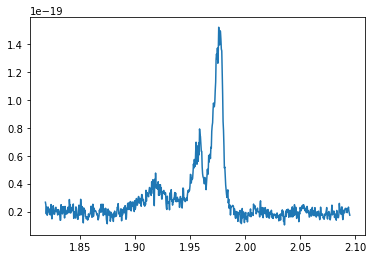

In [9]:
spec_test = cube.specextract(48, 48, radius=0)

Due to the fact that JWST/NIRSpec undersamples the PSF, bright point sources create undulations in the spectrum. We apply light smoothing with a circular aperture of radius 2.5 spaxels to account for this, and then plot the result.

In [10]:
cube.convolve(2.5)

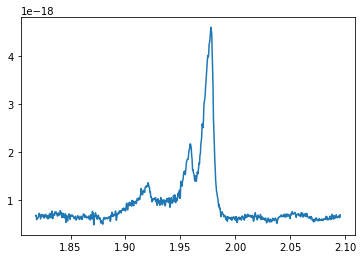

In [11]:
spec_conv = cube.specextract(48, 48, radius=0)

Now we'll write this convolved cube to disk, and redefine it as our input file for the fit.

In [12]:
cube.writefits(initdir+'nirspec-j1652-conv.fits')
q3di.infile = initdir+'nirspec-j1652-conv.fits'

This time, we are going to normalize to minimize numerical issues in the fitting.

In [13]:
q3di.argsreadcube = {'wmapext': None, 
                     'fluxunit_in': 'erg/s/cm2/micron',
                     'fluxnorm': 1e-17}
cube = q3di.load_cube()

Size of data cube: [ 86 , 77 , 700 ]
Wavelength range: [ 1.8184203 , 2.0952241 ]  micron


Let's double-check what we have:

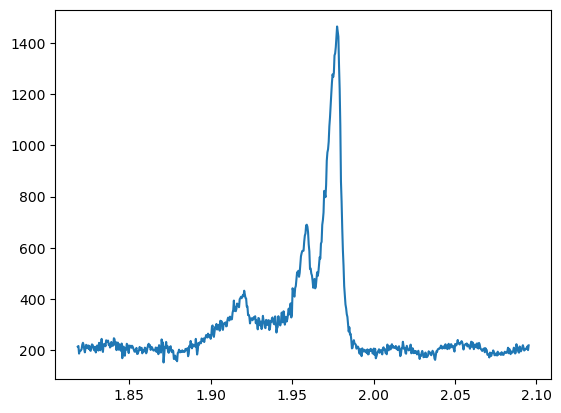

In [13]:
spec_test = cube.specextract(48, 48, radius=0)

Name and systemic redshift of the galaxy. `zsys_gas` is an input for calculating velocity maps in `q3dpro` and for initializing the arrays of initial guesses below.

In [14]:
q3di.name = 'J1652'
q3di.zsys_gas = 2.9489

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [15]:
q3di.fitrange = [1.82, 2.09]
#q3di.cutrange = np.array([,])

Create quasar template from the peak spaxel. We normalize so the template flux is around unity.

makeqsotempate: using peak spaxel in white light as center


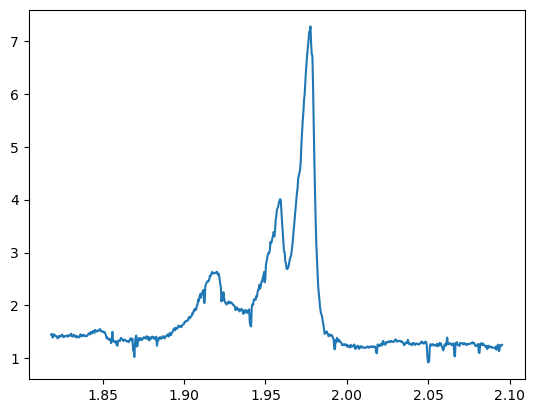

In [16]:
qsotemplate = outdir+'nirspec-j1652-quasar-template.npy'
cube.makeqsotemplate(qsotemplate, radius=0., norm=5e3)

### 1.3. Setting up the fitting parameters <a class="anchor" id="chapter1_3"></a>

#### 1.3.1. Emission-line parameters <a class="anchor" id="chapter1_3_1"></a>

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/q3dfit/data/linelists), or in `q3dfit/data/linelists/`.

In [17]:
lines = ['Hbeta', '[OIII]4959', '[OIII]5007']

This block sets up initial conditions for the emission-line fit to each spaxel. This initialization method adds a number of new attributes to the object. Emission lines are set to a common redshift and velocity dispersion, set to `q3di.zsys_gas` and 50 km/s by default. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines. Different initial conditions can also be set on a spaxel-by-spaxel and/or line-by-line basis. The default number of velocity components is 1. Here, we change this to 3.

In [18]:
q3di.init_linefit(lines, linetie='[OIII]5007', maxncomp=3)
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas'])

Because of the complexity of these line profiles, we change the default initial conditions. `zinit_gas` and `siginit_gas` are dictionaries of arrays that hold the initial conditions for each line, spaxel, and velocity component.

In [19]:
for i in lines:
    # narrow, redshifted component
    q3di.zinit_gas[i][:,:,2] = 2.959
    # broad, blueshifted component
    q3di.zinit_gas[i][:,:,1] = 2.9489
    q3di.siginit_gas[i][:,:,1] = 500.

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [20]:
# Global limit
q3di.siglim_gas = np.array([40., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run. The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut. Component checking can be disabled by setting `checkcomp = False`.

In [21]:
#q3di.checkcomp = False
q3di.argscheckcomp['sigcut'] = 3.
q3di.argscheckcomp['ignore']= ['Hbeta']

#### Line ratio constraints
Lines with ratios fixed by atomic physics have their ratios fixed automatically. Other line ratios can have bound constraints applied, or they can be fixed to a particular value.

`line1`, `line2`, and `comp` are required. `comp` is an array of velocity components (zero-indexed) on which to apply the constraints, one array for each pair of lines.

`value` is the initial value of `line1`/`line2`. Presently, if `value` is specified for one pair of lines, it must be specified for all. Otherwise, the initial value is determined from the data.

The ratio can be `fixed` to the initial value. Presently, if `fixed` is defined, it must be set to `True` or `False` for all pairs of line.

If the ratio is not `fixed`, `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) Presently, if `lower` or `upper` is defined here for one set of lines, it must be defined here for every pair of lines.

In [22]:
# Required columns:
# line1 = ['[NI]5198', '[SII]6716']
# line2 = ['[NI]5200', '[SII]6731']
# comp = np.array([[0], [0]], dtype=np.int32)

# Optional columns:
# value = [1.5, 1.]
# fixed = [True, False]
# lower = []
# upper = []

# Write table
# from astropy.table import QTable
# lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

# q3di.argslineinit['lineratio']=lineratio

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

This case applies to the GMOS B600 grating. Gemini website says R = 1688 at 4610 A for 0.5" slit, with IFU 0.31" eff. slit. This gives 1.69 A FWHM. I measure sometimes closer to 1.5-1.6 A.

In [23]:
spect_instrum = {'JWST_NIRSPEC':['G235H']}
q3di.spect_convol['ws_instrum'] = spect_instrum

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [24]:
#from q3dfit.common.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### Options to `lmfit` and `scipy.optimize.least_squares` (or `scipy.optimize.leastsq`, or other optimizer)
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html), or another method of choice. Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `method`: in particular, `leastsq` may be faster than `least_squares`
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Most parameters of `least_squares`/`leastsq` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac
- `tr_solver`: lsmr
- `loss`: soft_l1
- `ftol`, `gtol`, `xtol`
- `epsfcn`

In [25]:
#q3di.argslinefit['method'] = 'leastsq'
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-15:
#q3di.argslinefit['ftol'] = 1.e-10
#q3di.argslinefit['gtol'] = 1.e-10
#q3di.argslinefit['xtol'] = 1.e-10
# .. and the "suitable step length for the forward- difference approximation of the Jacobian. Normally the actual step length will be sqrt(epsfcn)*x"
# this is only for scipy.optimize.leastsq
#q3di.argslinefit['epsfcn'] = 1.e-15

#### 1.3.2 Continuum parameters <a class="anchor" id="chapter1_3_2"></a>

We next initialize the continuum. As part of this, we give it the name of our continuum fitting function. (See Rupke et al. 2017 for more details on the methodology of `q3dfit` when separating a quasar from its host galaxy.)

In [26]:
q3di.init_contfit('fitqsohost')
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas', 'fcncontfit', 'argscontfit', 'argsconvtemp', 'decompose_qso_fit', 'decompose_ppxf_fit', 'dividecont', 'ebv_star', 'fcnconvtemp', 'forcefloat64', 'keepstarz', 'maskwidths', 'maskwidths_def', 'masksig_secondfit', 'nolinemask', 'nomaskran', 'startempfile', 'startempvac', 'tweakcntfit', 'siginit_stars', 'zinit_stars'])

`q3dfit` first masks emission lines before fitting. The default mask value is 500 km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

For this case, the lines are quite broad and we change the default.

In [27]:
q3di.maskwidths_def = 2000.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`.
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`.
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.
- `refit` = Set to `ppxf` to fit (data - quasar) residual with stellar model.
- `blrpar` = Set of initial Gaussian parameters (flux, observed wavelength, sigma in km/s) for fitting empirical scattered-light model (relevant only for narrow set of cases).

In [28]:
q3di.argscontfit['qsoxdr'] = qsotemplate
q3di.argscontfit['qsoord'] = 2
q3di.argscontfit['hostord'] = 2
q3di.decompose_qso_fit = True

Optional arguments to `lmfit`. See above for a description in the case of line fits.

In [29]:
#q3di.argscontfit['method'] = 'leastsq'

argslmfit = dict()
argslmfit['ftol'] = 1.e-15
argslmfit['gtol'] = 1.e-15
argslmfit['xtol'] = 1.e-15
#argslmfit['epsfcn'] = 1.e-10

q3di.argscontfit['argslmfit'] = argslmfit

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3dfit import q3dfit
q3dfot(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [30]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy, q3di)

## 2. Run fit <a class="anchor" id="chapter2"></a>

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [31]:
cols = 45
rows = 29

Run the fit. Choose `quiet=False` for verbose output. An output object for each spaxel, of class `q3dout`, is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [32]:
from q3dfit.q3df import q3dfit
q3dfit(q3di,cols=cols,rows=rows, quiet=False)

Core 1: # spaxels fit=1
[col,row]=[45,29] out of [86,77]
FITLOOP: First call to FITSPEC
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5978e+04                                    1.55e+03    
       1              2         1.5978e+04      3.34e-02       1.00e-05       1.55e+03    
       2              3         1.5978e+04      6.69e-02       2.00e-05       1.55e+03    
       3              4         1.5977e+04      1.34e-01       4.00e-05       1.55e+03    
       4              5         1.5977e+04      2.68e-01       8.00e-05       1.55e+03    
       5              6         1.5977e+04      5.35e-01       1.60e-04       1.55e+03    
       6              7         1.5976e+04      1.07e+00       3.20e-04       1.55e+03    
       7              8         1.5973e+04      2.14e+00       6.40e-04       1.55e+03    
       8              9         1.5969e+04      4.28e+00       1.28e-03       1.55e+03    
  

      96             104        1.3128e+03      1.99e-05       1.99e-02       1.41e-03    
      97             105        1.3128e+03      1.22e-05       1.03e-02       8.93e-03    
      98             107        1.3128e+03      6.00e-06       1.13e-02       5.30e-03    
      99             108        1.3128e+03      4.13e-06       7.67e-03       3.97e-03    
      100            109        1.3128e+03      6.14e-06       5.79e-03       5.07e-03    
      101            110        1.3128e+03      1.45e-05       1.76e-02       4.00e-03    
      102            111        1.3128e+03      2.57e-05       3.46e-02       2.08e-02    
      103            113        1.3128e+03      8.44e-06       2.14e-02       2.35e-03    
      104            114        1.3128e+03      1.48e-05       9.05e-03       9.39e-03    
      105            115        1.3128e+03      9.93e-06       5.34e-02       1.15e-01    
      106            116        1.3128e+03      2.93e-05       9.16e-03       1.01e-02    

      192            211        1.3128e+03      1.14e-07       1.57e-04       1.56e-03    
      193            212        1.3128e+03      1.86e-06       2.56e-03       1.52e-03    
      194            213        1.3128e+03      2.00e-05       2.73e-02       1.43e-03    
      195            214        1.3128e+03      3.62e-06       4.92e-03       1.37e-03    
      196            215        1.3128e+03      2.05e-06       2.80e-03       1.35e-03    
      197            216        1.3128e+03      5.65e-07       7.73e-04       1.34e-03    
      198            217        1.3128e+03      5.10e-07       6.97e-04       1.33e-03    
      199            218        1.3128e+03      5.99e-08       8.18e-05       1.34e-03    
      200            219        1.3128e+03      3.98e-05       5.46e-02       3.92e-03    
      201            220        1.3128e+03      1.23e-05       1.68e-02       3.27e-03    
      202            221        1.3128e+03      1.16e-06       1.62e-03       3.23e-03    

      288            316        1.3128e+03      2.86e-06       4.25e-03       1.74e-03    
      289            317        1.3128e+03      3.66e-07       5.89e-04       1.65e-03    
      290            318        1.3128e+03      2.23e-06       3.67e-03       1.56e-03    
      291            319        1.3128e+03      5.07e-07       8.46e-04       1.52e-03    
      292            320        1.3128e+03      1.06e-05       1.83e-02       2.59e-03    
      293            321        1.3128e+03      3.18e-07       4.74e-04       2.55e-03    
      294            322        1.3128e+03      5.89e-08       8.93e-05       2.54e-03    
      295            323        1.3128e+03      3.67e-06       5.81e-03       1.71e-03    
      296            324        1.3128e+03      9.84e-07       1.69e-03       1.67e-03    
      297            325        1.3128e+03      1.77e-06       2.99e-03       1.59e-03    
      298            326        1.3128e+03      2.99e-06       4.96e-03       1.41e-03    

      385            415        1.3128e+03      1.23e-06       2.29e-03       7.00e-04    
      386            416        1.3128e+03      1.77e-06       3.29e-03       7.09e-04    
      387            417        1.3128e+03      2.96e-05       5.52e-02       2.28e-03    
      388            418        1.3128e+03      2.97e-06       5.58e-03       2.21e-03    
      389            419        1.3128e+03      3.78e-06       7.11e-03       2.14e-03    
      390            420        1.3128e+03      8.12e-07       1.52e-03       2.13e-03    
      391            421        1.3128e+03      1.44e-06       2.71e-03       2.11e-03    
      392            422        1.3128e+03      2.61e-06       4.89e-03       2.10e-03    
      393            423        1.3128e+03      4.33e-07       8.13e-04       2.09e-03    
      394            424        1.3128e+03      2.10e-07       3.94e-04       2.09e-03    
      395            425        1.3128e+03      1.30e-07       2.43e-04       2.08e-03    

      481            514        1.3128e+03      4.30e-07       9.25e-04       1.99e-03    
      482            515        1.3128e+03      3.01e-07       6.49e-04       1.91e-03    
      483            516        1.3128e+03      6.71e-07       1.45e-03       1.70e-03    
      484            517        1.3128e+03      1.57e-07       3.39e-04       1.66e-03    
      485            518        1.3128e+03      5.38e-08       1.16e-04       1.64e-03    
      486            519        1.3128e+03      6.42e-06       1.39e-02       5.55e-04    
      487            520        1.3128e+03      3.35e-06       7.23e-03       5.60e-04    
      488            521        1.3128e+03      4.56e-06       9.76e-03       5.05e-04    
      489            522        1.3128e+03      8.89e-08       1.94e-04       5.05e-04    
      490            523        1.3128e+03      2.44e-06       5.33e-03       5.32e-04    
      491            524        1.3128e+03      1.17e-05       2.52e-02       5.42e-04    

      578            612        1.3128e+03      4.27e-07       2.90e-04       9.42e-03    
      579            613        1.3128e+03      1.71e-06       1.19e-03       9.41e-03    
      580            616        1.3128e+03      1.51e-05       1.15e-02       5.19e-03    
      581            617        1.3128e+03      5.49e-07       9.11e-04       4.95e-03    
      582            618        1.3128e+03      1.65e-07       1.06e-04       3.51e-02    
      583            619        1.3128e+03      2.27e-07       4.02e-04       3.44e-02    
      584            620        1.3128e+03      6.87e-06       1.91e-02       5.87e-03    
      585            622        1.3128e+03      2.13e-06       6.62e-03       3.25e-03    
      586            623        1.3128e+03      1.45e-07       2.24e-04       2.93e-03    
      587            624        1.3128e+03      2.78e-07       4.59e-04       2.31e-03    
      588            625        1.3128e+03      7.76e-08       1.38e-04       2.16e-03    

      674            714        1.3128e+03      3.54e-05       9.62e-02       5.14e-03    
      675            715        1.3128e+03      3.67e-06       1.00e-02       4.84e-03    
      676            716        1.3128e+03      1.83e-05       5.03e-02       4.25e-03    
      677            717        1.3128e+03      9.55e-06       2.59e-02       4.44e-03    
      678            718        1.3128e+03      1.39e-06       3.82e-03       4.45e-03    
      679            719        1.3128e+03      8.48e-06       2.34e-02       4.43e-03    
      680            720        1.3128e+03      8.02e-07       2.21e-03       4.41e-03    
      681            721        1.3128e+03      6.24e-07       1.72e-03       4.39e-03    
      682            722        1.3128e+03      9.07e-05       2.53e-01       4.86e-02    
      683            723        1.3128e+03      2.26e-07       1.51e-05       1.47e-03    
      684            724        1.3128e+03      1.19e-04       3.55e-01       1.09e-02    

      770            814        1.3128e+03      2.15e-08       6.36e-05       1.26e-04    
      771            815        1.3128e+03      2.35e-07       6.94e-04       1.25e-04    
      772            816        1.3128e+03      5.38e-09       1.59e-05       1.25e-04    
      773            817        1.3128e+03      3.51e-06       1.04e-02       1.24e-04    
      774            818        1.3128e+03      5.79e-08       1.72e-04       1.23e-04    
      775            819        1.3128e+03      6.95e-06       2.07e-02       3.18e-04    
      776            820        1.3128e+03      9.58e-07       2.82e-03       2.73e-04    
      777            821        1.3128e+03      2.21e-06       6.56e-03       2.80e-04    
      778            822        1.3128e+03      2.16e-06       6.44e-03       3.23e-04    
      779            823        1.3128e+03      1.35e-05       4.00e-02       1.37e-03    
      780            824        1.3128e+03      2.37e-05       7.89e-02       2.45e-03    

      866            914        1.3128e+03      1.70e-07       4.73e-04       1.06e-03    
      867            915        1.3128e+03      2.45e-07       9.40e-04       1.76e-04    
      868            916        1.3128e+03      2.85e-07       1.84e-03       8.96e-04    
      869            917        1.3128e+03      2.39e-07       6.34e-04       8.63e-05    
      870            918        1.3128e+03      9.43e-08       3.11e-04       5.12e-05    
      871            919        1.3128e+03      2.21e-08       7.05e-05       5.10e-05    
      872            920        1.3128e+03      8.88e-09       2.81e-05       5.09e-05    
      873            921        1.3128e+03      2.86e-07       9.06e-04       5.90e-05    
      874            922        1.3128e+03      3.23e-08       9.74e-05       5.41e-05    
      875            923        1.3128e+03      5.70e-07       1.72e-03       4.43e-05    
      876            924        1.3128e+03      1.67e-07       5.23e-04       4.43e-05    

      962           1012        1.3128e+03      5.32e-10       1.63e-06       3.40e-04    
      963           1013        1.3128e+03      1.36e-07       4.20e-04       3.24e-04    
      964           1014        1.3128e+03      2.75e-06       8.45e-03       8.07e-05    
      965           1015        1.3128e+03      1.84e-07       5.67e-04       8.29e-05    
      966           1016        1.3128e+03      1.83e-08       5.61e-05       8.22e-05    
      967           1017        1.3128e+03      8.08e-07       2.48e-03       9.43e-05    
      968           1018        1.3128e+03      5.28e-07       1.62e-03       9.75e-05    
      969           1019        1.3128e+03      1.12e-07       3.42e-04       9.27e-05    
      970           1020        1.3128e+03      9.80e-08       3.00e-04       9.42e-05    
      971           1021        1.3128e+03      1.10e-08       3.37e-05       9.24e-05    
      972           1022        1.3128e+03      5.55e-08       1.71e-04       9.22e-05    

     1058           1110        1.3127e+03      1.46e-03       4.26e-02       4.80e-01    
     1059           1111        1.3126e+03      6.90e-03       2.05e-01       6.17e-01    
     1060           1112        1.3126e+03      2.19e-02       6.60e-01       9.46e-01    
     1061           1114        1.3126e+03      1.12e-02       4.00e-01       2.13e+00    
     1062           1115        1.3126e+03      1.28e-02       4.02e-01       1.00e+00    
     1063           1116        1.3126e+03      7.42e-04       7.85e-04       4.64e-02    
     1064           1117        1.3126e+03      3.62e-04       1.22e-02       9.68e-01    
     1065           1118        1.3126e+03      6.13e-04       2.02e-02       2.67e-01    
     1066           1119        1.3126e+03      4.09e-04       1.24e-02       1.18e+00    
     1067           1120        1.3126e+03      1.48e-03       5.91e-02       7.40e-01    
     1068           1121        1.3126e+03      3.77e-04       5.46e-04       5.37e-01    

     1155           1212        1.3122e+03      4.35e-03       1.71e-01       4.26e-01    
     1156           1213        1.3122e+03      8.89e-03       3.41e-01       5.95e-02    
     1157           1214        1.3122e+03      8.50e-04       3.61e-02       5.14e-02    
     1158           1215        1.3122e+03      2.04e-04       8.52e-03       5.03e-02    
     1159           1216        1.3122e+03      1.23e-02       5.47e-01       2.63e+00    
     1160           1217        1.3122e+03      1.29e-02       6.22e-01       7.31e-01    
     1161           1218        1.3122e+03      5.86e-04       2.21e-03       6.97e-01    
     1162           1219        1.3122e+03      2.78e-04       5.05e-04       3.00e-01    
     1163           1220        1.3122e+03      3.64e-03       1.27e-01       3.44e-01    
     1164           1221        1.3122e+03      5.92e-05       2.64e-04       2.49e-01    
     1165           1222        1.3122e+03      6.25e-03       2.47e-01       3.31e-01    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9037e+03                                    1.40e+04    
       1              2         4.1545e+03      4.75e+03       1.53e+02       2.87e+03    
       2              3         3.3548e+03      8.00e+02       8.18e+01       6.66e+02    
       3              4         3.1501e+03      2.05e+02       4.22e+01       1.27e+03    
       4              5         3.0341e+03      1.16e+02       1.39e+02       1.36e+03    
       5              6         2.8633e+03      1.71e+02       9.98e+01       1.30e+03    
       6              7         2.4563e+03      4.07e+02       1.50e+02       7.42e+02    
       7              8         2.1997e+03      2.57e+02       9.88e+01       1.86e+03    
       8              9         2.1638e+03      3.60e+01       2.98e+01       1.23e+03    
       9             10         2.1200e+03      4.38e+01       2.75e+01       3.07e+02    

      26             27         1.6512e+03      5.47e+00       3.93e+00       1.08e+01    
      27             28         1.6506e+03      6.01e-01       3.58e-01       6.51e+01    
      28             29         1.6503e+03      3.35e-01       6.50e-01       9.18e+00    
      29             30         1.6499e+03      4.02e-01       3.65e-01       4.29e+01    
      30             31         1.6495e+03      3.21e-01       1.06e+00       7.38e+00    
      31             32         1.6494e+03      1.34e-01       1.72e-01       3.22e+01    
      32             33         1.6492e+03      2.55e-01       1.26e+00       4.87e+00    
      33             34         1.6486e+03      5.58e-01       1.49e-01       4.96e+00    
      34             35         1.6485e+03      1.36e-01       9.95e-02       3.16e+00    
      35             37         1.6481e+03      3.50e-01       5.03e-01       9.81e+00    
      36             38         1.6481e+03      8.65e-03       1.20e-02       3.51e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7083e+04                                    1.67e+03    
       1              2         1.7083e+04      5.06e-02       1.41e-05       1.67e+03    
       2              3         1.7083e+04      1.01e-01       2.83e-05       1.67e+03    
       3              4         1.7083e+04      2.02e-01       5.66e-05       1.66e+03    
       4              5         1.7082e+04      4.04e-01       1.13e-04       1.66e+03    
       5              6         1.7081e+04      8.09e-01       2.26e-04       1.66e+03    
       6              7         1.7080e+04      1.62e+00       4.53e-04       1.66e+03    
       7              8         1.7077e+04      3.23e+00       9.05e-04       1.66e+03    
       8              9         1.7070e+04      6.47e+00       1.81e-03       1.66e+03    
       9             10         1.7057e+04      1.29e+01       3.62e-03       1.66e+03    

      96             108        1.3899e+03      5.70e-04       1.45e-01       2.97e-01    
      97             109        1.3899e+03      3.13e-04       3.15e-02       1.15e-01    
      98             110        1.3899e+03      7.47e-04       2.76e-01       8.50e+00    
      99             111        1.3899e+03      7.42e-03       1.82e-01       2.77e+00    
      100            112        1.3899e+03      2.68e-03       7.92e-02       9.45e-01    
      101            113        1.3899e+03      6.83e-04       2.50e-02       5.82e-01    
      102            114        1.3899e+03      2.24e-04       4.05e-04       8.92e-01    
      103            115        1.3898e+03      1.09e-02       3.00e-01       6.98e+00    
      104            116        1.3898e+03      1.75e-02       4.82e-01       8.52e+00    
      105            117        1.3898e+03      3.98e-03       2.56e-03       5.62e-01    
      106            118        1.3898e+03      2.68e-02       5.99e-01       1.22e+01    

      192            207        1.3838e+03      7.46e-04       3.33e-03       2.20e-01    
      193            208        1.3838e+03      2.37e-03       4.39e-02       1.34e+00    
      194            209        1.3838e+03      5.28e-04       1.71e-03       1.34e+00    
      195            210        1.3838e+03      8.25e-04       2.88e-03       5.03e-01    
      196            211        1.3838e+03      5.00e-02       8.69e-01       7.87e+00    
      197            212        1.3838e+03      1.51e-02       3.75e-03       3.68e-01    
      198            213        1.3838e+03      1.12e-03       4.01e-03       7.34e-01    
      199            215        1.3838e+03      4.04e-03       4.06e-02       6.01e-01    
      200            216        1.3838e+03      1.04e-03       2.19e-02       8.79e-01    
      201            217        1.3838e+03      5.31e-04       1.46e-03       3.22e-01    
      202            218        1.3837e+03      1.49e-02       2.03e-01       3.06e-01    

      288            306        1.3834e+03      4.67e-08       2.26e-03       1.79e-02    
      289            308        1.3834e+03      6.12e-08       3.17e-03       7.70e-03    
      290            309        1.3834e+03      5.45e-09       1.21e-06       2.97e-04    
      291            311        1.3834e+03      5.03e-09       1.33e-03       9.39e-05    
      292            312        1.3834e+03      6.44e-10       4.28e-04       7.40e-05    
      293            313        1.3834e+03      3.20e-10       6.37e-05       6.56e-05    
      294            314        1.3834e+03      1.15e-09       9.38e-04       6.88e-05    
      295            315        1.3834e+03      5.76e-10       1.60e-04       4.78e-05    
      296            316        1.3834e+03      3.42e-10       9.76e-05       3.98e-05    
      297            317        1.3834e+03      6.92e-10       2.07e-04       1.57e-05    
      298            318        1.3834e+03      7.58e-10       1.42e-03       4.45e-05    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4684e+04                                    2.48e+03    
       1              2         2.4683e+04      7.16e-02       1.41e-05       2.48e+03    
       2              3         2.4683e+04      1.43e-01       2.83e-05       2.48e+03    
       3              4         2.4683e+04      2.86e-01       5.66e-05       2.48e+03    
       4              5         2.4682e+04      5.73e-01       1.13e-04       2.48e+03    
       5              6         2.4681e+04      1.15e+00       2.26e-04       2.48e+03    
       6              7         2.4679e+04      2.29e+00       4.53e-04       2.48e+03    
       7              8         2.4674e+04      4.58e+00       9.05e-04       2.48e+03    
       8              9         2.4665e+04      9.16e+00       1.81e-03       2.48e+03    
       9             10         2.4647e+04      1.83e+01       3.62e-03       2.48e+03    

       3              4         1.9986e+03      4.10e-01       3.11e+00       2.95e+01    
       4              5         1.9985e+03      8.54e-03       2.79e-01       2.87e+00    
       5              6         1.9985e+03      2.02e-04       7.17e-02       7.75e-01    
       6              7         1.9985e+03      4.95e-06       5.77e-03       4.59e-02    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 2.7230e+03, final cost 1.9985e+03, first-order optimality 4.59e-02.
[[Model]]
    (((((Model(manygauss, prefix='Hbeta_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f9940c61e80>') + Model(manygauss, prefix='Hbeta_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f9940c61e80>')) + Model(manygauss, prefix='lbOIIIrb4959_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f9940c61e80>')) + Model(manygauss, prefix='lbOIIIrb4959_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f9940c61e80>')) + Model(manygauss, prefix=

## 3. Plot fit results <a class="anchor" id="chapter3"></a>

Load the output of a fit.

In [33]:
cols = 45
rows = 29
from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)
* `IR`: set to `True` to use infrared-style plot

In [34]:
argsplotline = dict()
argsplotline['nx'] = 2
argsplotline['ny'] = 1
argsplotline['line'] = ['Hbeta', '[OIII]5007']
argsplotline['size'] = [0.05, 0.07]

Run the plot method. The output can be saved as a jpg by specifying `savefig=True`. A default filename is used, which can be overridden by specifying `outfile=file`. The output file will have the suffix `_lin` attached, so that the actual filename will be "file_lin.jpg".

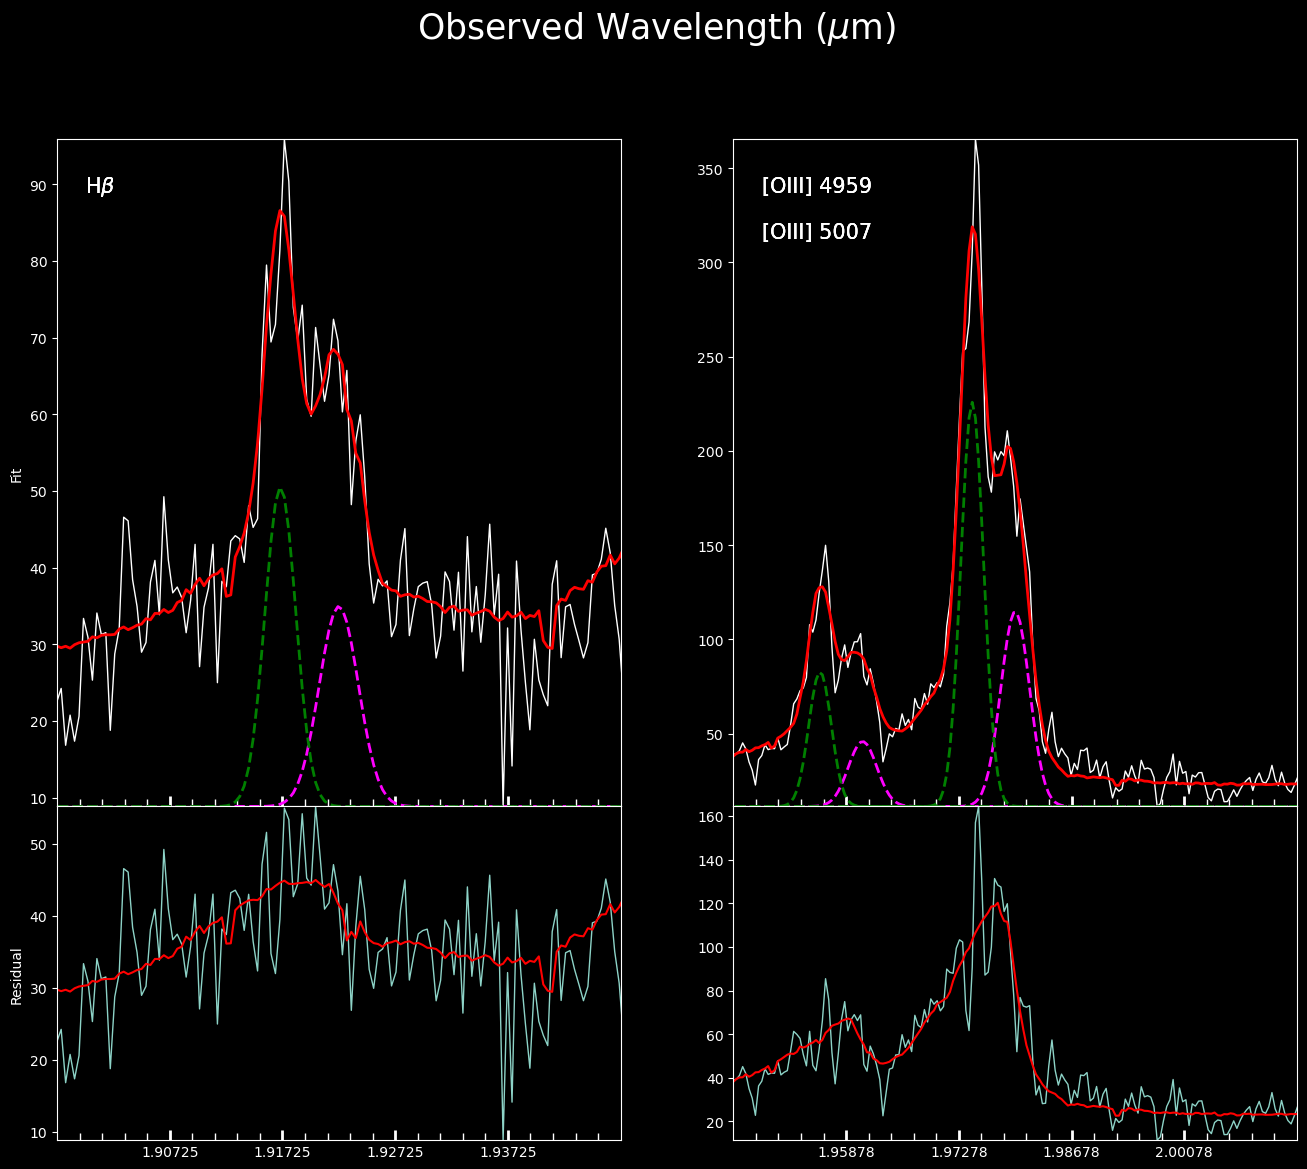

In [35]:
q3do.plot_line(q3di,plotargs=argsplotline)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength.

In [36]:
argscontplot = dict()
argscontplot['xstyle'] = 'lin'
argscontplot['ystyle'] = 'lin'
argscontplot['fluxunit_out'] = 'flambda'
argscontplot['mode'] = 'dark'

Run two methods. The first computes the continuum values to plot, and the second does the plotting.

Because we specified `decompose_qso_fit=True` in the `q3di` object, three plots are created: one for the host-only light, one for quasar-only light, and one for the total continuum.

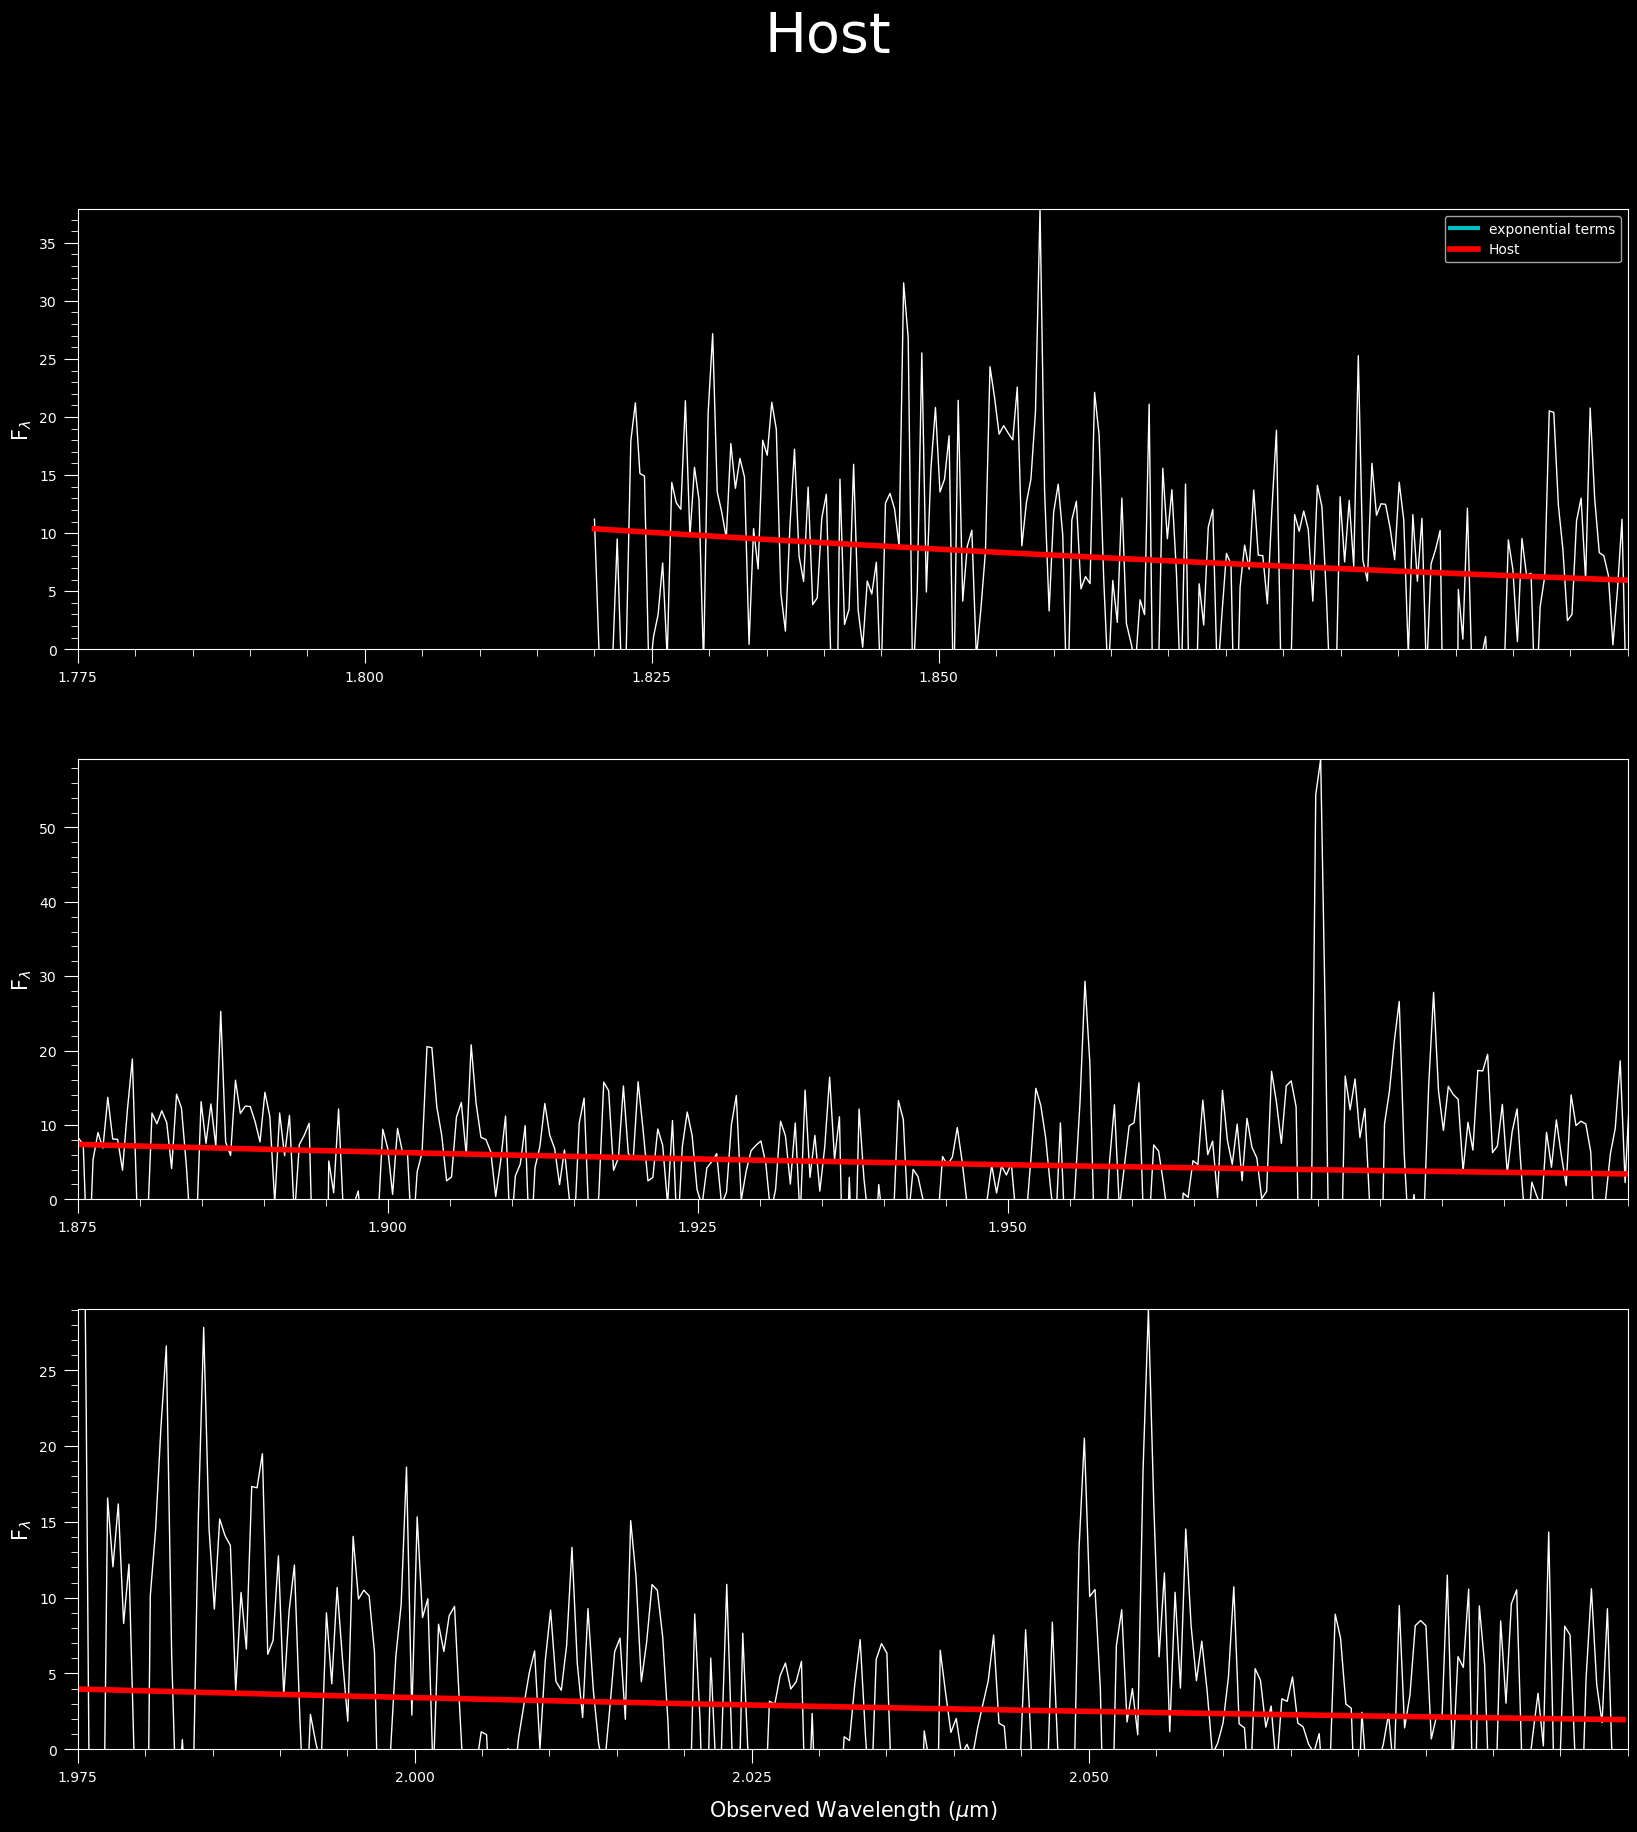

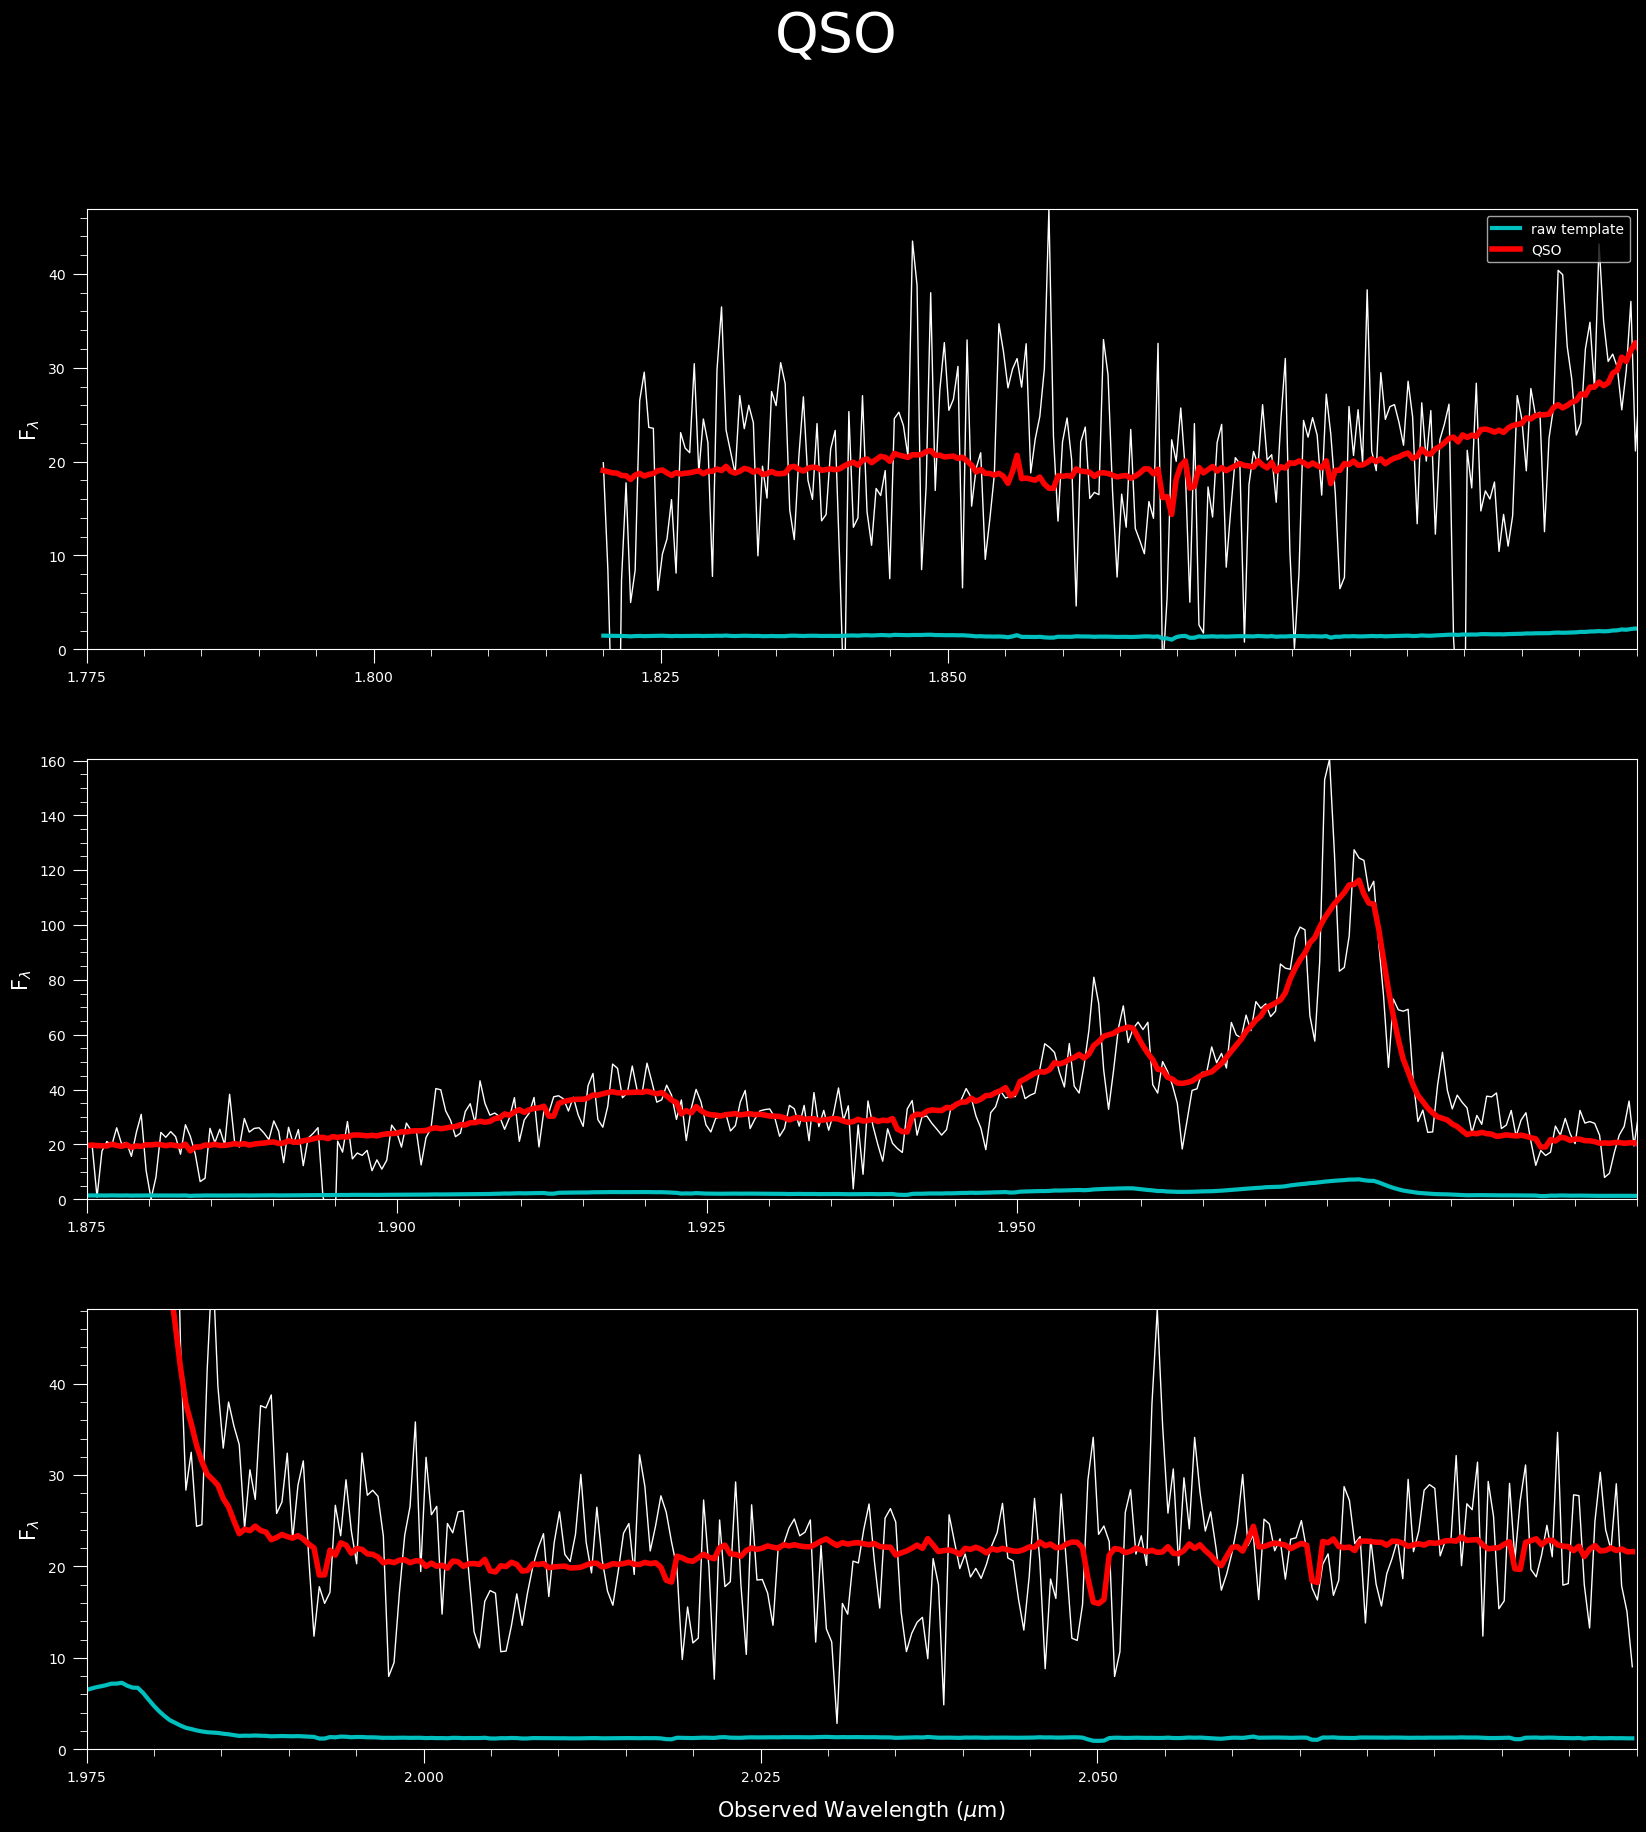

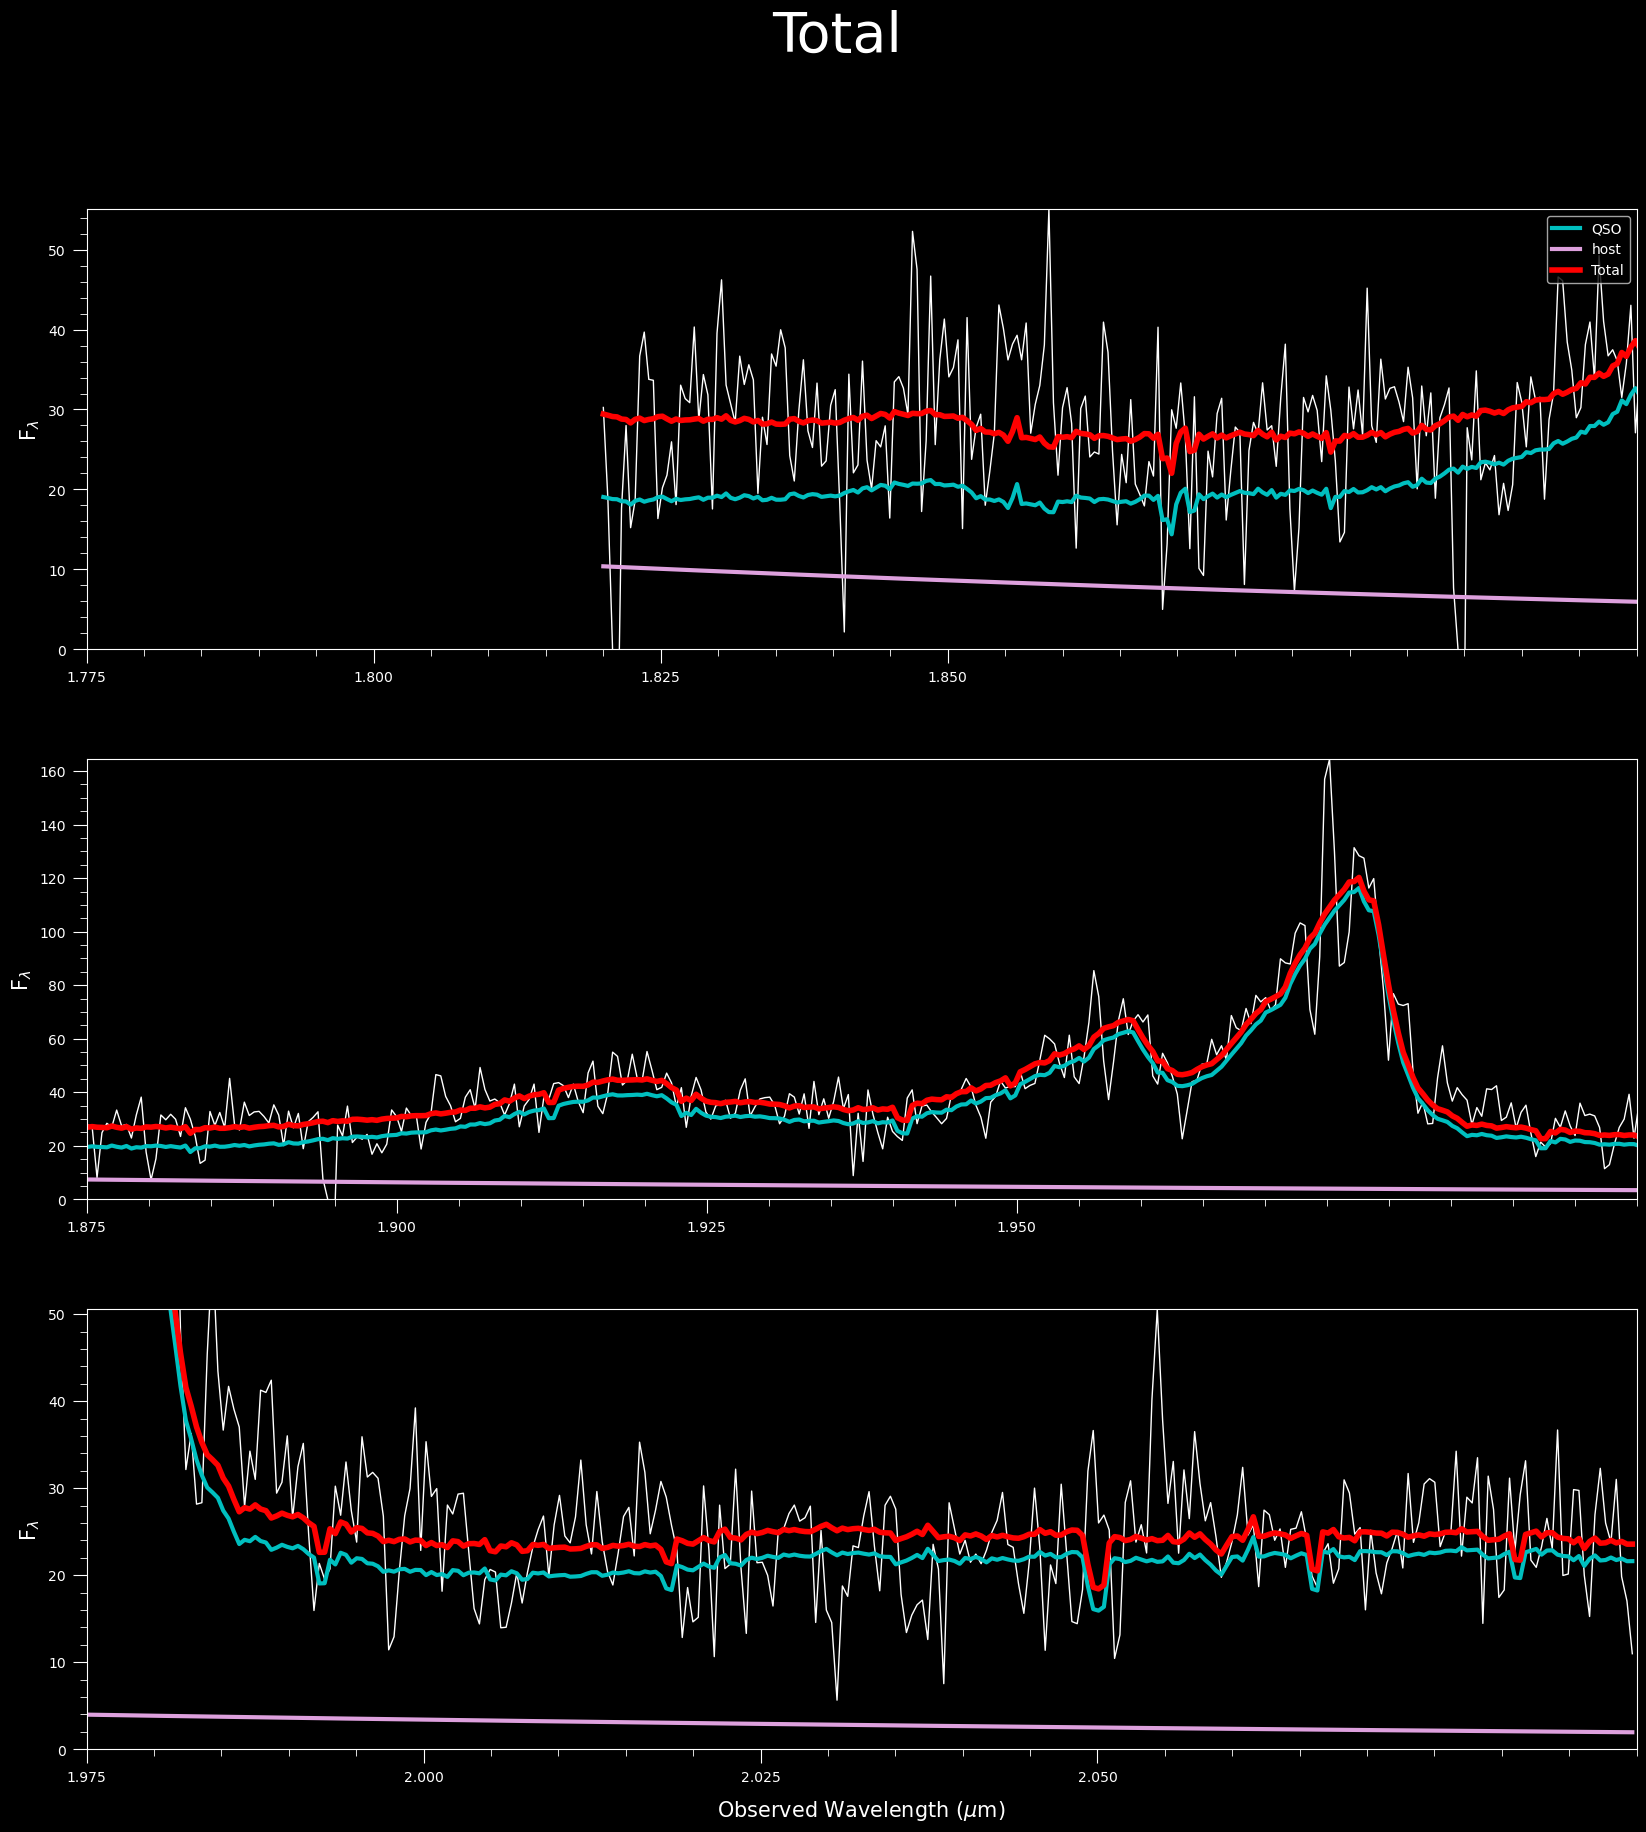

In [14]:
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)

## 4. Combine fit results from all spaxels.<a class="anchor" id="chapter4"></a>

This routine takes all of the spaxels you fit and combines the line- and continuum-fitting results together. The outputs are saved into two files. This example assumes that the spaxels listed here in each dimension have been fit.

In [38]:
cols = [20, 75]
rows = [15, 70]
from q3dfit.q3dcollect import q3dcollect
q3dcollect(q3di, cols=cols, rows=rows)

q3dcollect: Saving emission-line fit results into nirspec-j1652/j1652.line.npz
q3dcollect: Saving continuum fit results into nirspec-j1652/j1652.cont.npy


## 5. Plot science products. <a class="anchor" id="chapter5"></a>

These routines take the output of `q3dcollect` and process them further for science output. The `q3dpro` class has methods to make maps of physical quantities.

In [39]:
import q3dfit.q3dpro as q3dpro
qpro = q3dpro.Q3Dpro(q3di, PLATESCALE=0.025, NOCONT=True)

Start by plotting linemaps for [OIII], of both flux and velocity measures. The parameters listed below control the plotting.

Plotting emission line maps
getting line data... [OIII]5007


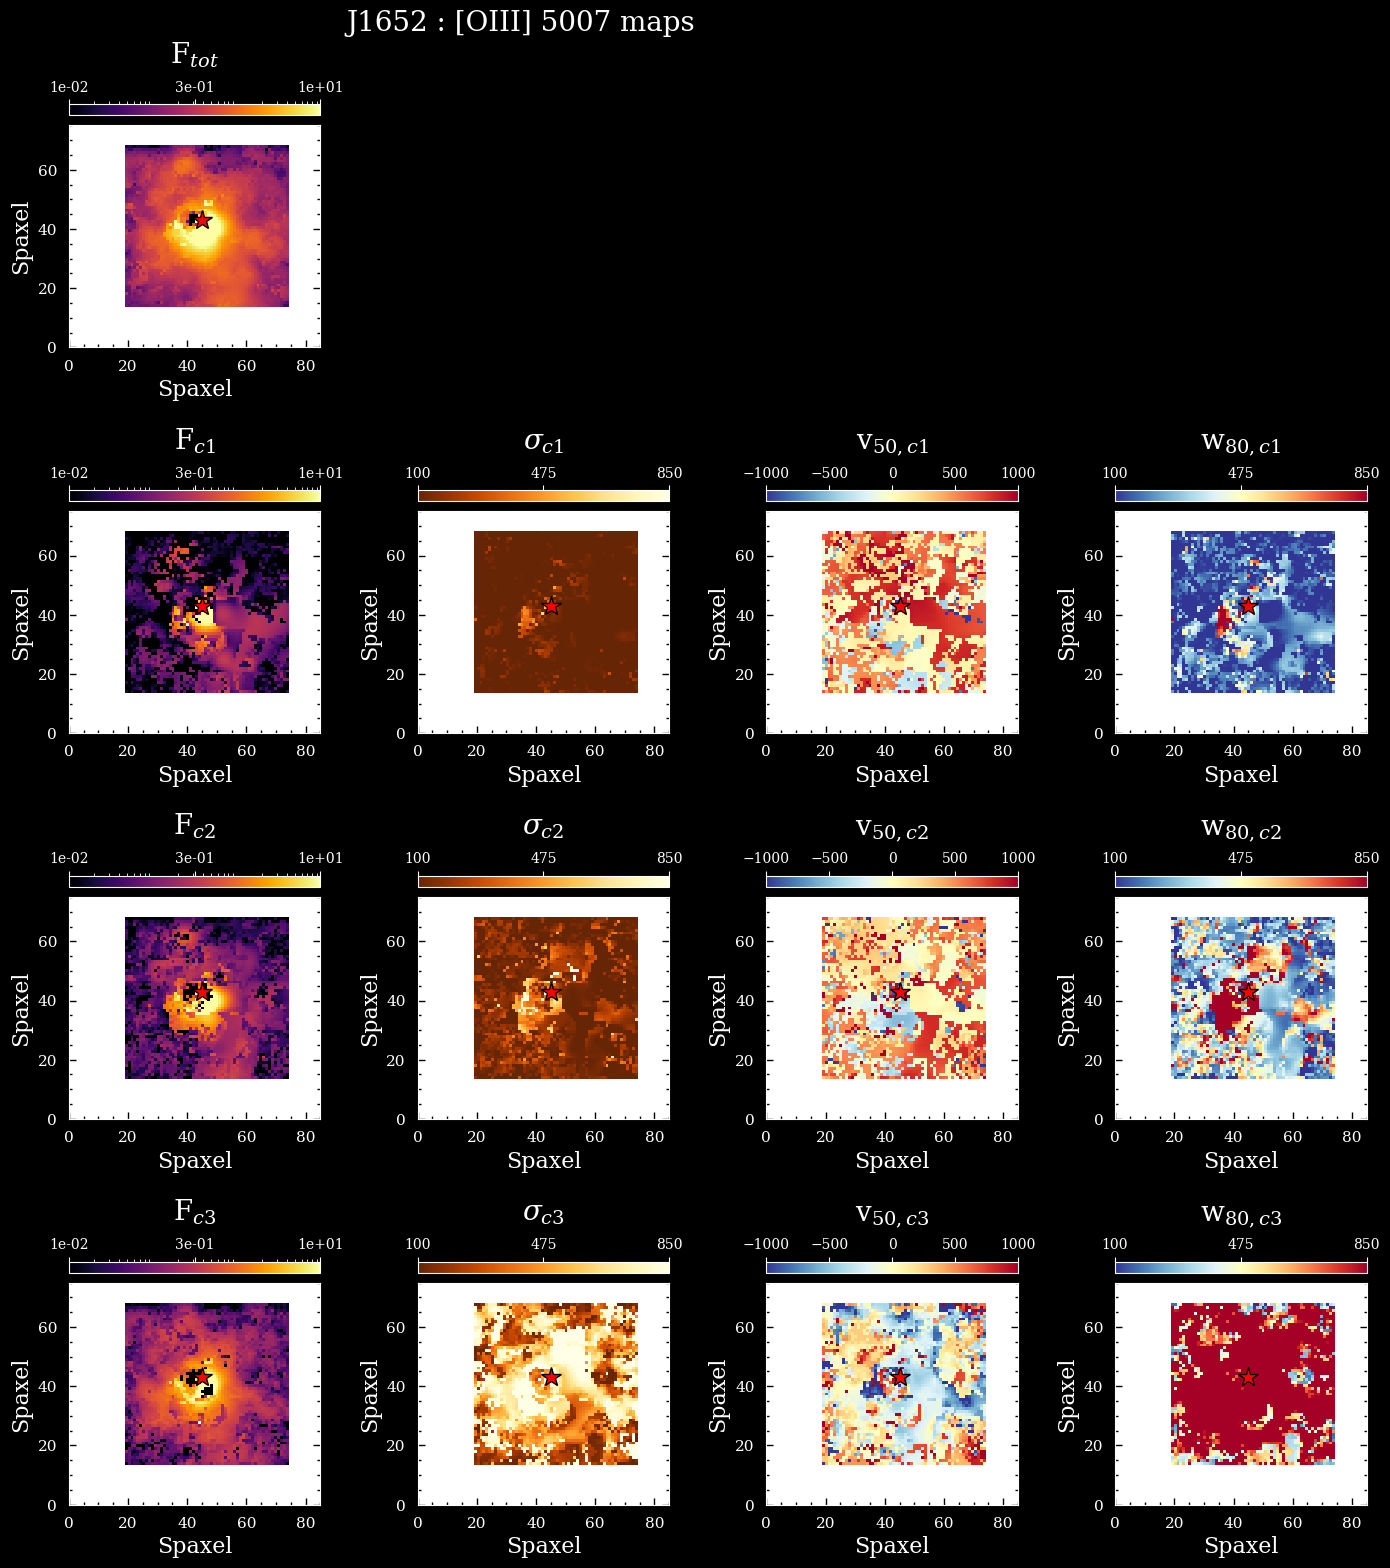

In [40]:
do_kpc = False
saveFile = False
flx = [1e-2,1e1]
qsocenter = [45., 43.]
pltarg = {'Ftot':flx,
          'Fci':flx,
          'Sig':[100.,850.],
          'v50':[-1000.,1000.],
          'w80':[100.,850.],
          'fluxlog': True}
qpro.make_linemap('[OIII]5007', XYSTYLE=do_kpc, xyCenter=qsocenter,
                  SAVEDATA=saveFile, VMINMAX=pltarg, PLTNUM=1, CMAP='inferno')

Map of [OIII]/H$\beta$ for each component, and for the total flux:

getting line data... Hbeta
getting line data... [OIII]5007
calculating line ratios...


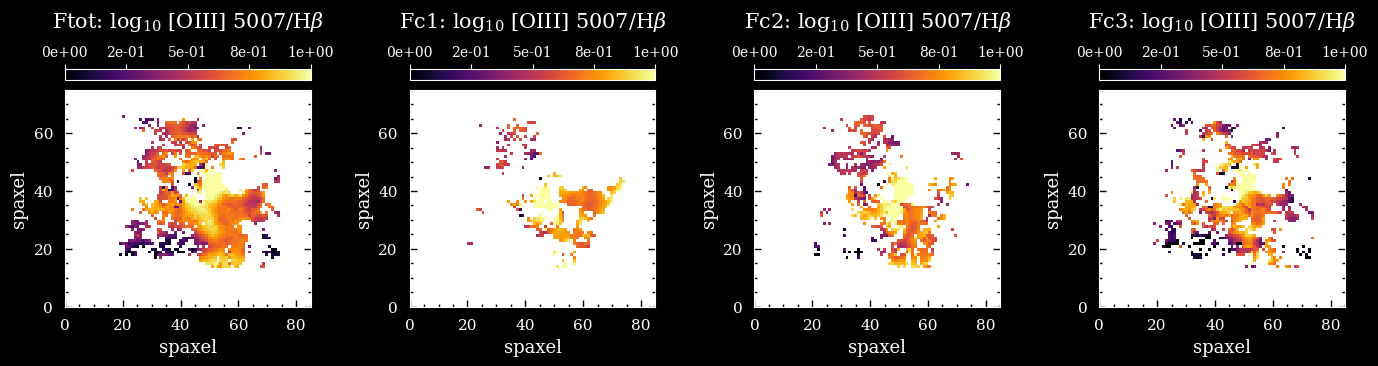

In [41]:
qpro.make_lineratio_map('[OIII]5007', 'Hbeta', VMINMAX=[0,1])

Map of v50 over the cumulative velocity distribution:

Saving  J1652-[OIII]5007-v50-map  to  nirspec-j1652/


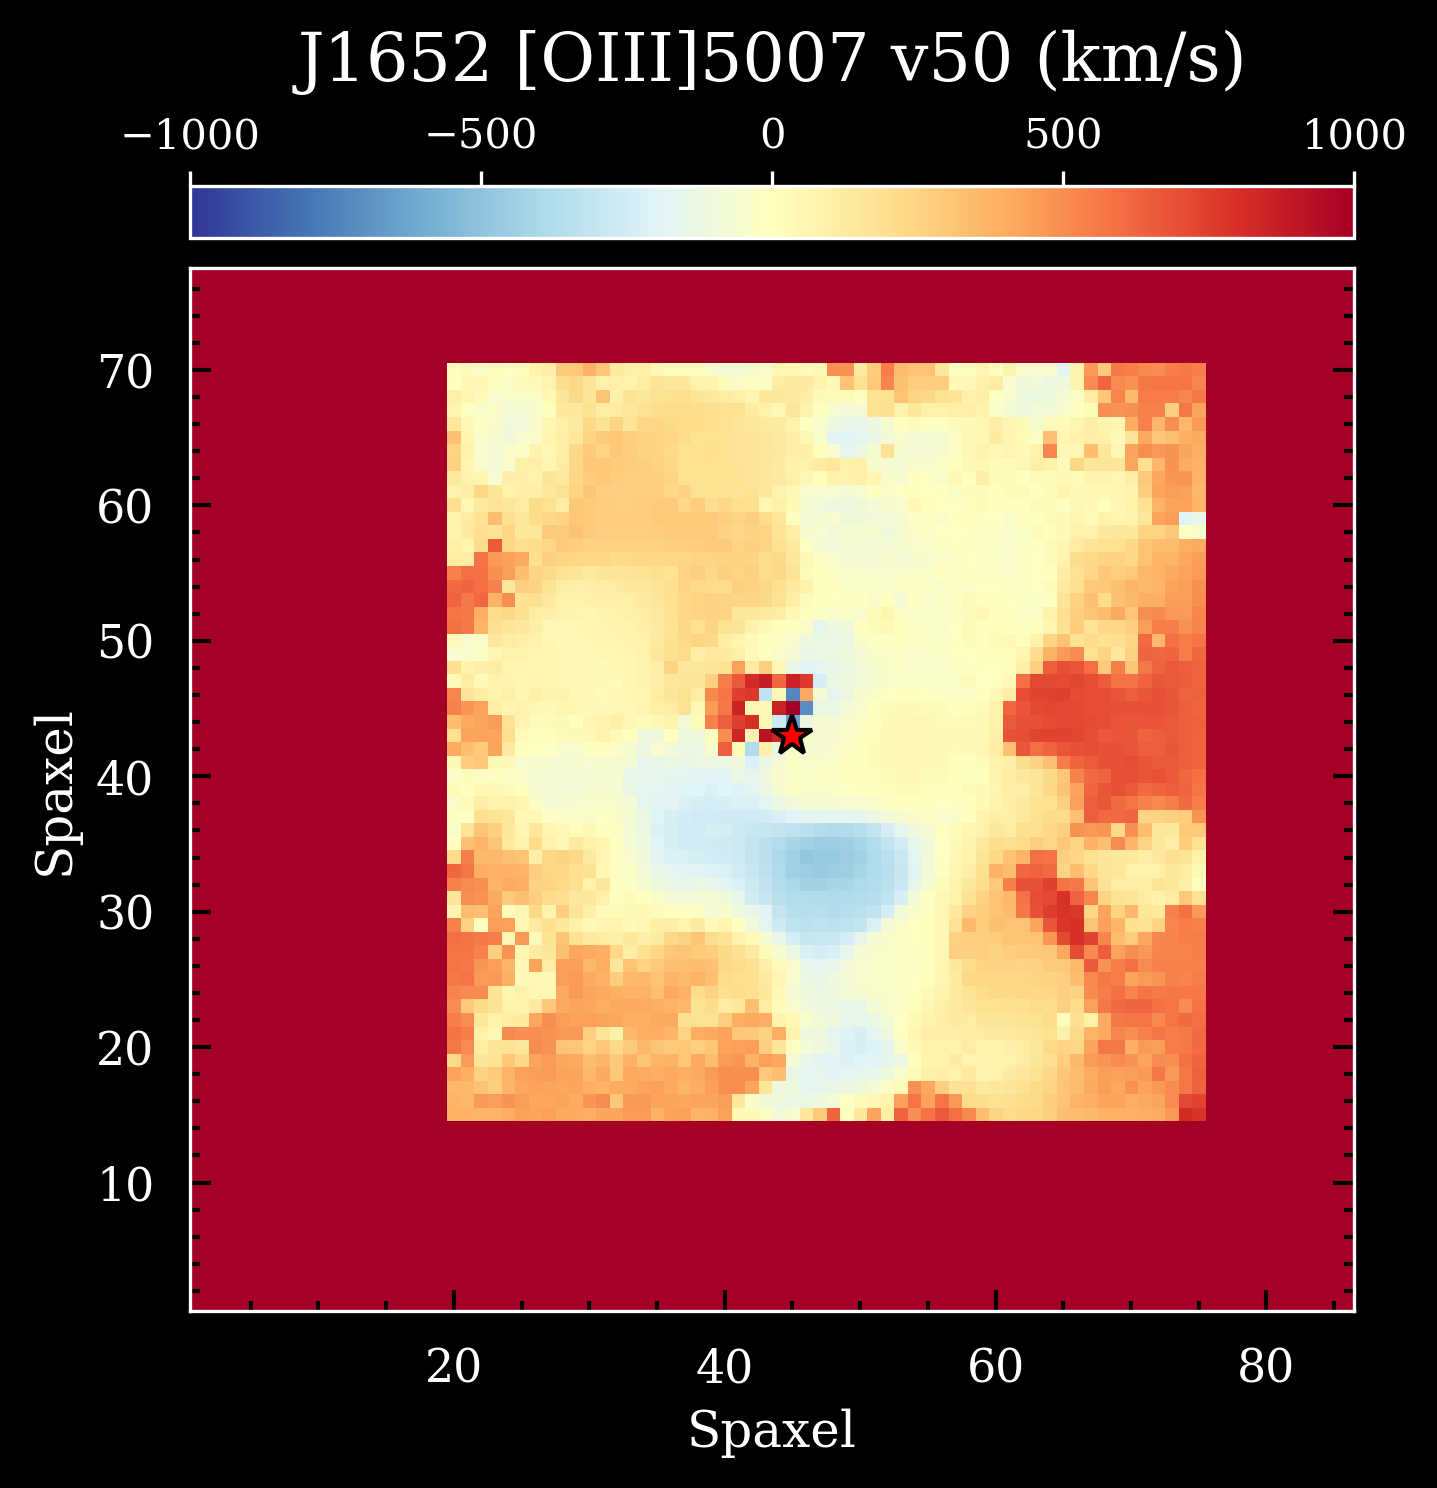

In [42]:
from q3dfit.q3dpro import OneLineData
o3data = OneLineData(qpro.linedat, '[OIII]5007')
o3data.calc_cvdf(2.9489, [-1e3, 1e3], vstep=5)
o3data.make_cvdf_map(50., velran=[-1e3, 1e3], markcenter=[45., 43.],
                     outfile=True)

Map of W80 over the cumulative velocity distribution:

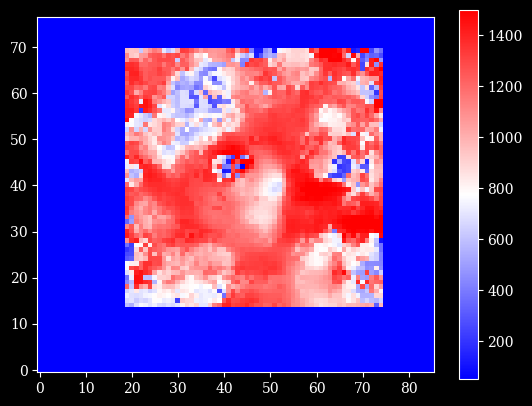

In [43]:
from matplotlib.pyplot import *
imshow(o3data.calc_cvdf_vel(90, calc_from_posvel=False).T - o3data.calc_cvdf_vel(10, calc_from_posvel=False).T, 
       origin='lower', cmap='bwr', vmin=50, vmax=1500)
colorbar()